<a href="https://colab.research.google.com/github/ankanghosh/mountaincar-dqn-tf/blob/main/Reinforcement_Learning_with_TensorFlow_Solving_MountainCar_v0_with_Deep_Q_Network_using_TF_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning with TensorFlow: Solving MountainCar-v0 with Deep Q-Network using TF-Agents

There are many applications of Reinforcement Learning (RL) - a branch of ML where an agent learns to make decisions by interacting with an environment and receiving rewards as feedback. Examples include game-playing AI, robotics control, recommendation systems, traffic signal optimization, resource management, and autonomous driving. In RL, the agent improves its actions over time by receiving rewards or penalties based on its performance. This blog will focus on solving the classic `MountainCar-v0` problem using a Deep Q-Network (DQN) built with TensorFlow Agents (TF-Agents).

## Introduction


This tutorial is an adaptation of the official CartPole-environment-based [TensorFlow DQN agent tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) to solve the `MountainCar-v0` environment using the following enhancements. See the DQN paper [here](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).


1.   ε-decay for improved exploration-exploitation balance.
2.   Reward shaping to accelerate learning in sparse-reward settings.
1.   Hyperparameter tuning to improve convergence and stability.

The goal in `MountainCar-v0` is to drive an underpowered car up a hill and reach a flag. Since gravity is stronger than the engine, the agent must learn to rock back and forth to build momentum and reach the flag. This tutorial guides you through each component of a RL pipeline, covering the data collection, training, and evaluation processes.

## Setup

Install the necessary system packages for rendering and video generation.

In [ ]:
# Install the necessary system packages for rendering and video generation.
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,929 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,520 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/

Install the necessary Python dependencies, including libraries for rendering, video recording, and core deep RL packages.

In [ ]:
# Install the Python dependencies.
!pip install "imageio==2.4.0"
!pip install pyvirtualdisplay
!pip install tensorflow==2.15.0 tf-agents[reverb]==0.19.0
!pip install pyglet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.0-py3-none-any.whl size=3303893 sha256=023f0b466f4a3ddc8a64f7e6c4ff0e025c360842dffa508cd1b4006471ee3567
  Stored in directory: /root/.cache/pip/wheels/00/d9/a6/102182c294ff3e90d8d0679ad48e3aa3aa61f7fa02061120c5
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.37.0
    Uninstalling imageio-2.37.0:
      Successfully uninstalled imageio-2.37.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.0 which is incompatible.
scikit-image 0.25.2 requires imageio!=2.35.0,>=2.33, but you have imageio 2.4.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 3.1 MB/s eta 0:00:00


Ensure compatibility with `tf.keras` (Keras 2.x).

In [ ]:
# Ensure compatibility with "tf.keras" (Keras 2.x).
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

Define the imports for Future, standard library, third-party packages, and TF-Agents.

In [ ]:
# Future imports.
from __future__ import absolute_import, division, print_function

# Standard library.
import base64

# Third-party packages.
import gym
from gym import RewardWrapper
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb
import tensorflow as tf
import IPython.display

# TF-Agents imports.
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.networks import q_network, sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.policies import random_tf_policy, py_tf_eager_policy
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import dynamic_step_driver, py_driver
from tf_agents.specs import tensor_spec

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Confirm that the installed TensorFlow version is the intended one.

In [ ]:
# Confirm that the installed TensorFlow version is the intended one.
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


Set up a virtual display for rendering OpenAI Gym environments.

In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Environment

In RL, the environment defines the task or problem the agent must solve. In TF-Agents, standard environments can be loaded using the `tf_agents.environments` suites, which support sources like OpenAI Gym, Atari, and DM Control. Load the `MountainCar-v0` environment from the OpenAI Gym suite.

In [ ]:
# "MountainCar-v0" environment.
env_name = "MountainCar-v0"

# Load environment using TF-Agents suite.
preview_env = suite_gym.load(env_name)

Go ahead and inspect the `MountainCar-v0` setup. A car can be seen trying to climb up a mountain.

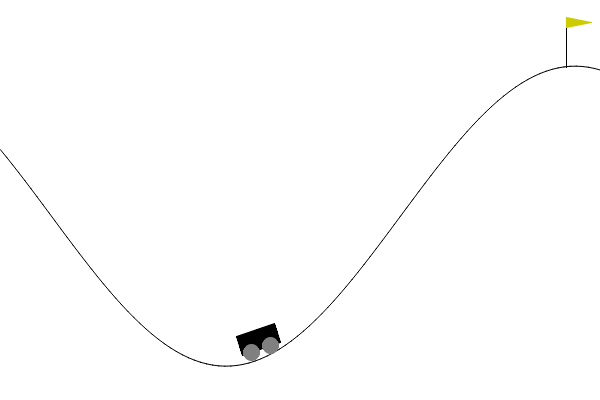

In [ ]:
# Reset the environment before rendering a new episode frame.
preview_env.reset()

# Render a single frame from the environment and display it as an image.
PIL.Image.fromarray(preview_env.render())

Instantiate one environment for training and another one for evaluation.

In [ ]:
# Load Python environments for training and evaluation.
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

Next, wrap the environments for TF-Agents. Like most environments, the `MountainCar-v0` environment is written in pure Python and is required to be converted to TensorFlow using the `TFPyEnvironment` wrapper. The original environment operates with NumPy arrays, while the `TFPyEnvironment` acts as a bridge by converting them into `Tensors`, making the environment compatible with TensorFlow-based agents and policies.

In [ ]:
# Convert Python environments for training and evaluation to TF-Agents environments.
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

**Note:** The standard environment loading and wrapping process has been demonstrated here for clarity. However, the actual training environment used later will incorporate reward shaping and be redefined in the “Reward Shaping” section.

### Observation and action spaces

The `MountainCar-v0` environment provides the following observation or state space and the action space.

*   **Observation Space:** A Two-Dimensional (2D) continuous space representing:
 *   **`position:`** Values in the range ~`−1.2` to `0.6`.
 *   **`velocity:`** Values in the range: ~−`0.07` to `0.07`.
*   **Action Space:** A discrete space with 3 actions shown below.
 *   **`0`**: Accelerate to the left.
 *   **`1:`** Do not accelerate.
 *   **`2:`** Accelerate to the right.

In the `MountainCar-v0` environment, the agent receives a reward of `-1` at each time step (an interaction with the environment) until it reaches the goal. The agent must learn to build momentum by oscillating between left and right to climb the hill and reach the goal at `position ≥ 0.5`. Also note that in the `MountainCar-v0` environment, an episode also terminates automatically after 200 time steps if the agent has not reached the goal. Learn more about the `MountainCar-v0` environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car/).

Next, display the specifications for the observation and action.

**Note:** In this tutorial, “specifications” and “specs” will be used interchangeably.

## Hyperparameters

With `MountainCar-v0`, rewards are sparse and delayed. Hyperparameters play a crucial role. Note that in RL, each experience is typically stored as a tuple `(s, a, r, s′)`, where:
*   **`s`:** Current state.
*   **`a`:** Action taken.
*   **`r`:** Reward received.
*   **`s'`:** Next state after the action.

Also note the following definition.

*   **Episode:** One complete run from environment reset to terminal state.
*   **Training Step:** One iteration of environment interaction and learning (gradient) update. It can involve multiple interactions of the agent in the environment, where each interaction represents a transition from state `s` to state `s′` after taking an action `a`. This interaction is also denoted by a time step. Also, note that an iteration is typically shorter than a full episode.
*   **Replay Buffer:** A memory that stores experience tuples `(s, a, r, s′)` for sampling during training, enabling off-policy learning - where the agent learns from past data collected by earlier versions of the same policy, rather than only from the most recent one.

It is important to have clarity about the role of a policy in RL. A policy is the decision-making function that maps states to actions and is continuously updated as the agent learns from the environment and past experiences, ideally converging towards an optimal policy. The optimal policy is the best possible action strategy that maximizes the total reward over time.

Start with the following set of hyperparameter values.

In [ ]:
num_iterations = 150000  #  Number of training iterations.

# Initial experience collection before training starts.
initial_collect_steps = 10000

# Number of environment steps or agent interactions to collect per training iteration.
collect_steps_per_iteration = 4

# Maximum size of the replay buffer.
replay_buffer_max_length = 100000

# Batch size for sampling from replay buffer.
batch_size = 256

# Learning rate for the optimizer.
learning_rate = 5e-4

# Log training progress every "N" steps.
log_interval = 200

# Evaluation settings.
num_eval_episodes = 10  # Number of episodes to average over during evaluation.
eval_interval = 1000  # Evaluate the agent every "N" training steps.

## Custom ε-decay scheduler: Balance exploration and exploitation

With sparse rewards from the `MountainCar-v0` environment, it is important to balance exploration and exploitation by implementing an ε-decay scheduler. In RL, exploration means trying random actions to discover new strategies, while exploitation means using the best-known actions (with highest Q-value according to the current Q-network; see subsection "DQN agent" to learn more about Q-value) to maximize rewards. Early in training, high exploration helps the agent discover successful behaviors, but too much exploration prevents convergence (achieving the goal). Conversely, too much exploitation too early can trap the agent in suboptimal policies before it has learned effective strategies.

Early in training, the agent explores more (high `ε`), but gradually reduces `ε` to act more greedily. Decay `ε` linearly from `1.0` to `0.01` over the training period to start with more exploration and gradually favor exploitation. We will use this to create a custom ε-greedy policy that wraps the agent’s `collect_policy`, injecting ε-decay into the data collection process. This custom policy becomes a separate, second policy that is used specifically for data collection - the agent interacts with the environment using this policy and stores the resulting experiences in the replay buffer.

In [ ]:
class EpsilonDecayScheduler:
    def __init__(self, initial_epsilon=1.0, final_epsilon=0.01, decay_duration=25000):
        # Epsilon starts at "1.0" (fully random actions).
        self.initial_epsilon = initial_epsilon
        # Final value of epsilon after decay (mostly greedy actions).
        self.final_epsilon = final_epsilon
        # Number of steps over which epsilon decays.
        self.decay_duration = decay_duration

    def get_epsilon(self, step):
        # Use TensorFlow operations instead of Python operations.
        # Convert step and decay duration to "float" tensors.
        step = tf.cast(step, tf.float32)
        decay_duration = tf.cast(self.decay_duration, tf.float32)

        # Compute how far along the decay process we are.
        decay_ratio = tf.minimum(step / decay_duration, 1.0)

        # Linearly interpolate epsilon between initial and final values.
        epsilon = self.initial_epsilon - decay_ratio * (self.initial_epsilon - self.final_epsilon)

        # Ensure epsilon never goes below "final_epsilon".
        return tf.maximum(epsilon, self.final_epsilon)

# Instantiate the scheduler to track and compute epsilon values as training progresses.
epsilon_scheduler = EpsilonDecayScheduler()

# We will inject this "ε" into a custom policy later when we wrap the collect policy.

## Reward shaping: Modify rewards to speed up learning

The `MountainCar-v0` environment only gives a reward of `-1` at every time step (interaction with the environment) until the car reaches the goal, making it hard for the agent to learn. To help the agent progress faster, we introduce reward shaping - giving additional reward when the car moves closer to the flag (i.e., increases its position) and gains momentum (i.e., moves with higher velocity). This shaped reward does not change the optimal policy, but makes it easier to learn.

As the next step, build a reward shaping wrapper that gives small positive feedback as the car gets closer to the flag and adds a bonus when it moves faster. This helps learning in the sparse-reward regime. `position + 1.2` scales the reward since the mountain car’s position ranges from ~`−1.2` to `0.6`, while `abs(velocity)` provides a signal that encourages acceleration.

In [ ]:
class ShapedMountainCarEnv(gym.RewardWrapper):
    def reward(self, reward):
        # Extract the car's current position and velocity from the environment's internal state.
        position = self.unwrapped.state[0]
        velocity = self.unwrapped.state[1]

        # Apply reward shaping:
        # - Add a positive reward proportional to the position ("+1.2" shifts it to be always positive).
        # - Add a velocity bonus (absolute value) to encourage building momentum.
        # This shaped reward helps the agent explore better and speeds up learning.
        return reward + 0.1 * (position + 1.2) + 0.1 * abs(velocity)

Go ahead and load the reward shaping wrapper. Apply the custom Gym `RewardWrapper` only to the training environment. The evaluation environment remains unchanged to ensure fair performance measurement.

Also, before wrapping the environment for use with TF-Agents, inspect the original Gym environment’s observation and action spaces. This helps understand what the agent will perceive and control before any transformations.

In [ ]:
# Create raw Gym environment and apply reward shaping.
raw_env = ShapedMountainCarEnv(gym.make(env_name))

# Show raw Gym environment specs before wrapping.
print("Raw Observation Space:", raw_env.observation_space)
print("Raw Action Space:", raw_env.action_space)

# Wrap raw Gym environment using TF-Agents Gym wrapper.
shaped_py_env = suite_gym.wrap_env(raw_env)

# Replace ONLY "train_env" with shaped version.
train_env = tf_py_environment.TFPyEnvironment(shaped_py_env)

# "eval_env" remains unchanged (vanilla).

Raw Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Raw Action Space: Discrete(3)


## Observation, reward, and action specs

TF-Agents uses a `TimeStep` structure to represent interaction at each step. When `env.step(action)` is called, it takes an `action` in the environment and returns a `TimeStep` tuple containing the following.

*   **`step_type`**:  Integer flag indicating if it is the first, mid (intermediate or middle steps in an episode), or last step `(FIRST, MID, LAST)`.
*   **`reward`**: Scalar reward received after the action.
*   **`discount`**: Scalar discount factor (usually `1.0` unless it is the terminal state). A discount factor is a scalar (e.g., 0.99) that reduces the value of future rewards compared to the immediate ones. It helps the agent prioritize short-term vs. long-term rewards and ensures convergence during training.
*   **`observation`**: Current state, includes the shape of observations, the data, types, alongside the ranges of allowed values.

The structure of this returned data is defined by the `time_step_spec()` method, which returns the specification of the `TimeStep` tuple. The method defines the structure of observations, rewards, and discounts returned at each step, while `action_spec()` defines the structure of the expected input from the agent.

Inspect the `TimeStep` tuple's specifications (observation, reward, and action) to understand how data flows between the environment and agent.

In [ ]:
# Inspect the observation specification of the "TimeStep" tuple.
print("Observation Spec:")
print(train_env.time_step_spec().observation)

# Inspect the reward specification of the "TimeStep" tuple.
print("Reward Spec:")
print(train_env.time_step_spec().reward)

# Inspect the action specification of the "TimeStep" tuple.
print("Action Spec:")
print(train_env.action_spec())

Observation Spec:
BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation', minimum=array([-1.2 , -0.07], dtype=float32), maximum=array([0.6 , 0.07], dtype=float32))
Reward Spec:
TensorSpec(shape=(), dtype=tf.float32, name='reward')
Action Spec:
BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2))


The specs help verify the following and help define the agent’s data collection logic.

*   Defining the input / output shapes of neural networks.
*   Understanding observation and action bounds (shape and range).
*   Designing the agent’s data collection and training pipelines.
*   Defining the reward format.

Take a quick look at a sample interaction to better understand how TF-Agents environments work. Reset the environment to obtain the initial `TimeStep`, then take a sample action (`2` → push right) and observe the resulting `TimeStep`. This shows how the environment returns observations, rewards, and step metadata.

In [ ]:
# Step through once.
time_step = train_env.reset()
print("Sample TimeStep:")
print(time_step)

action = np.array(2, dtype=np.int32)  # Push right.
next_time_step = train_env.step(action)
print("Next TimeStep:")
print(next_time_step)

Sample TimeStep:
TimeStep(
{'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.5562014,  0.       ]], dtype=float32)>})
Next TimeStep:
TimeStep(
{'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.93537134], dtype=float32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.5549573 ,  0.00124413]], dtype=float32)>})


## Agent

In RL, the decision-making component - the entity that interacts with the environment and improves its behavior over time by maximizing rewards - is called an agent. The agent uses an algorithm to learn from its experience in the environment. TF-Agents provides ready-made implementations of popular algorithms like [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), [REINFORCE (Reward Increment = Nonnegative Factor × Offset Reinforcement × Characteristic Eligibility)](https://people.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf), [Deep Deterministic Policy Gradient (DDPG)](https://arxiv.org/pdf/1509.02971), [Twin Delayed Deep Deterministic Policy Gradient (TD3)](https://arxiv.org/pdf/1802.09477), [Proximal Policy Optimization (PPO)](https://arxiv.org/abs/1707.06347), and [Soft Actor-Critic (SAC)](https://arxiv.org/abs/1801.01290). Each is suited to a different class of environments and tasks.

In this case, the agent controls the mountain car and must learn to drive it up the hill. For the learning algorithm, this work will focus exclusively on DQN, which is well-suited for problems with discrete action spaces - exactly the case with `MountainCar-v0`, where the agent can push left, push right, or do nothing.

### DQN agent

A DQN agent relies on a Q-network - an implementation of the classic RL algorithm [Q-learning](https://doi.org/10.1007/BF00992698), built using a deep neural network that learns to estimate the “quality” or expected future reward of each possible action in a given state. The model receives an environment observation (current state) and outputs Q-values (expected returns) for all of the possible actions in the state. DQNs, introduced by DeepMind in 2015, enhanced earlier Q-learning approaches by using deep neural networks at scale, experience replay (see section "Experience Replay and Replay Buffer"), and a target network (see subsection "Create and initialize the agent"), enabling them to solve multiple Atari games. Learn more about the Q-network and DQN from [this](https://www.tensorflow.org/agents/tutorials/0_intro_rl) TensorFlow tutorial.


Create the Q-network using `tf_agents.networks`. The network comprises a sequence of `tf.keras.layers.Dense` layers with Rectified Linear Unit (ReLU) activations, which help the model learn non-linear patterns by passing only positive values. Initialize the weights using `VarianceScaling` with a `fan_in` mode and a `truncated_normal` distribution - this ensures proper weight magnitudes based on the number of input connections, aiding in stable training. The final layer outputs one Q-value per available action and does not apply any activation function. Its weights are initialized using a `RandomUniform` distribution in a small range to start outputs near `0`, and biases are set to a small constant (`-0.2`) to slightly encourage exploration at the start. To build the network, use TF-Agents’ `sequential.Sequential`, which helps chain the `Dense` layers together.

In [ ]:
# Define the fuly connected hidden layer sizes for the Q-network.
fc_layer_units = (100, 50)

# Determine the number of actions from the environment's action spec.
action_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_spec.maximum - action_spec.minimum + 1

# Helper function to construct a ReLU-activated "Dense" layer.
def dense_layer(units):
    return tf.keras.layers.Dense(
        units,
        activation="relu",
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode="fan_in", distribution="truncated_normal"))

# Build the hidden layers of the Q-network.
dense_layers = [dense_layer(units) for units in fc_layer_units]

# Final layer outputs Q-values for each possible action.
q_values_output = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

# Combine the layers to form the Q-network.
q_net = sequential.Sequential(dense_layers + [q_values_output])

### Create and initialize the agent

To bring it all together, instantiate a `DqnAgent` using the defined Q-network. This is achieved using `tf_agents.agents.dqn.dqn_agent`. Specify the following along with the model.

*   `time_step_spec` and `action_spec` - the expected structure of interactions between the agent and the environment, which are required to interface with the environment.
*   An `AdamOptimizer` for adaptive learning rate optimization.
*   A Temporal Difference (TD) error-based loss function (squared TD error).
*   A counter to keep track of the training steps.

Internally, the DQN agent maintains two Q-networks given below.

*   An online Q-network, used for action selection and learning. It is updated at every training step.
*   A target Q-network, a delayed copy of the online network used to compute stable target Q-values. It is updated less frequently.

Updating the Q-network here implies that the network’s weights are adjusted using gradient descent during training. For the online network, this happens at every step. For the target network, the weights are periodically replaced with the current weights of the online network, not learned directly.

In RL, agents learn from predicted returns vs. actual outcomes. The difference between the predicted Q-value (from the online Q-network) and the target Q-value (based on actual reward received + estimated future rewards from the target Q-network) is called the TD error. Minimizing the TD error is central to how DQN agents learn and improve. During training, the agent minimizes this difference by computing the squared TD error and using it as a loss to update the weights of the online Q-network. This ensures the agent gradually aligns its predictions with actual long-term rewards. See [this](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) TensorFlow tutorial to learn more about how the DQN agent works theoretically.

In [ ]:
# Set up the optimizer for training the Q-network.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Counter to keep track of how many training steps have been completed.
train_step_counter = tf.Variable(0)

# Construct the DQN agent.
agent = dqn_agent.DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    target_update_period=1000)

# Initialize internal variables and prepare the agent for training.
agent.initialize()

## Policies: How the agent chooses actions

In RL, a policy defines the agent’s behavior - how it chooses actions based on the current observation. The goal of training is to improve the policy until it consistently produces desired behavior. In this tutorial, the following holds true.

*   The goal is to learn how to drive the car up the hill.
*   Based on the observation (the current state of the environment - position and velocity) at each time step (represented by `time_step`), the policy decides an action - whether to accelerate left or right.

### Two policies in every agent

TF-Agents conveniently bundles two policies inside every agent. See below.

1.   **`agent.policy`:** The policy to be evaluated or deployed after training.
2.   **`agent.collect_policy`:** The policy used while interacting with the environment to collect data.

In [ ]:
# Extract evaluation policy (used during testing / deployment).
eval_policy = agent.policy

# Extract data collection policy (used during training).
collect_policy = agent.collect_policy

Sometimes, the performance of a policy is compared against a random baseline. TF-Agents provides `RandomTFPolicy` through `tf_agents.policies.random_tf_policy`, which simply picks a random valid action at each `time_step`.

In [ ]:
# Create a random policy for the training environment.
random_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(),  # Expected input format.
    train_env.action_spec())     # Valid action range.

To get an action from any policy, pass in a `time_step` (which contains the current observation) into the `policy.action()` method. The policy returns a `PolicyStep`, a named tuple with the following components.

1.   **`action`:** The action to take (e.g., `0` or `1`).
2.   **`state`:** For stateful systems, such as Recurrent Neural Networks or RNNs (not used here).
3.   **`info`:** Any extra metadata, such as log-probabilities of actions.

In [ ]:
# Reset the training environment to get the initial time_step.
time_step = train_env.reset()

# Query the random policy to get an action for this time_step.
action_step = random_policy.action(time_step)

By default, `agent.policy` (used for evaluation or deployment) and `agent.collect_policy` are both greedy, meaning they always select the best-known action. In greedy mode, the action for the evaluation policy is selected as the `argmax` of Q-values predicted by the online Q-network. The target Q-network is never used for action selection - it is only referenced during training updates to compute stable target values. However, to encourage exploration during training, the agent’s `collect_policy` is wrapped with a custom ε-greedy policy (`EpsilonGreedyPolicy`). This wrapper chooses a random action with probability `ε`, and the learned (greedy) action otherwise. The `ε` value decays over time via the `epsilon_scheduler`. This setup ensures effective exploration during training while maintaining deterministic behavior during evaluation or deployment.

Both policies are continually updated as the agent learns - since they rely on the underlying Q-network, which is trained to better approximate the true optimal action-values or Q-values over time. As learning progresses, the agent becomes more accurate in selecting the action that truly leads to the highest expected reward.

In [ ]:
# Custom epsilon-greedy policy wrapper that switches between random and learned policy based on epsilon.
class EpsilonGreedyPolicy:
    def __init__(self, policy, epsilon_scheduler):
        self._policy = policy  # The base policy (typically "agent.collect_policy").
        self._epsilon_scheduler = epsilon_scheduler  # Scheduler to provide decaying epsilon values.

    def action(self, time_step, policy_state=()):
        epsilon = self._epsilon_scheduler.get_epsilon(agent.train_step_counter)  # Get current epsilon value.

        random_value = tf.random.uniform(())  # Sample a random float between "0" and "1".

        def choose_random():
            return random_policy.action(time_step)  # Select an action using the random policy.

        def choose_greedy():
            return self._policy.action(time_step, policy_state)  # Select an action using the learned policy.

        return tf.cond(
            random_value < epsilon,  # With probability "epsilon", act randomly.
            choose_random,
            choose_greedy,           # Otherwise, act greedily.
        )

    def get_initial_state(self, batch_size):  # Required by TF-Agents drivers to maintain stateful policies.
        return self._policy.get_initial_state(batch_size)

    @property
    def time_step_spec(self):  # Specifies the format of "time_step" inputs.
        return self._policy.time_step_spec

    @property
    def action_spec(self):  # Specifies the structure of actions returned by the policy.
        return self._policy.action_spec

    @property
    def policy_state_spec(self):  # Specifies the structure of internal policy state.
        return self._policy.policy_state_spec

    @property
    def info_spec(self):  # Specifies the format of auxiliary information returned by the policy.
        return self._policy.info_spec

# Wrap the agent's "collect_policy" with epsilon-greedy behavior.
epsilon_greedy_policy = EpsilonGreedyPolicy(agent.collect_policy, epsilon_scheduler)

## Metrics and Evaluation: How good is the policy?

To measure how well a policy (agent's evaluation policy) is doing, a reliable metric is needed. The most widely used one in RL is average return.

*   Return is the sum of rewards the agent receives over a single episode.
*   The policy is run over multiple episodes and the average is computed to get a stable estimate.

This helps in monitoring learning progress and comparing performance between different policies - like a trained agent versus a random baseline. See other common RL metrics available in TF-Agents [here](https://github.com/tensorflow/agents/tree/master/tf_agents/metrics).

Define a function that performs the following tasks.

1.   Runs the agent’s policy in the environment for multiple episodes.
2.   Tracks the cumulative reward in each episode.
3.   Returns the average reward per episode.

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0

    for _ in range(num_episodes):
        # Reset environment at the beginning of each episode.
        time_step = environment.reset()
        episode_return = 0.0

        # Run until episode ends.
        while not time_step.is_last():
            action_step = policy.action(time_step)     # Get action from policy.
            time_step = environment.step(action_step.action)  # Take an action in the environment.
            episode_return += time_step.reward         # Accumulate reward.

        total_return += episode_return

    # Compute average over episodes.
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

The function `compute_avg_return()` can be used to evaluate any policy. For instance, running it on the random policy will provide us with a baseline that is useful for comparing against the learning agent later.

In [ ]:
# Compute average return.
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-200.0

## Experience Replay and Replay Buffer: Store and sample past experiences

When training RL agents like DQN, relying only on the latest transition `(s, a, r, s′)` for updates makes learning unstable and inefficient. That is where Experience Replay comes in. Instead of discarding transitions after one use, they are stored in a buffer called the Replay Buffer, and batches are sampled randomly during training. This has two big advantages.

*   **Improved Data Efficiency:** A batch of transitions is updated for every new real interaction, allowing reuse across multiple updates.
*   **Greater Stability:** Random sampling breaks correlations in sequential data (sequence of transitions), stabilizing training.

This idea was introduced in the original [Atari DQN paper](https://arxiv.org/abs/1312.5602) and is now a standard component in most off-policy RL algorithms.

To store and retrieve the data (transitions) collected from the environment, use [Reverb](https://github.com/google-deepmind/reverb) - an easy-to-use and high-performance replay system from DeepMind. The experience data from trajectories is stored by this replay buffer.

Go ahead and set up a Reverb replay buffer table that stores agent experiences using First-In, First-Out (FIFO) eviction and uniform random sampling, ensuring efficient and stable training data management. Note that each agent provides an `agent.collect_data_spec`, which describes the shape and type of data or tensors it expects to store and train on.

In [ ]:
# Define the table name to store experiences.
table_name = "uniform_table"

# Get the spec (structure) of data that will be stored in the buffer.
# Ensures the data spec is in TensorFlow format.
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)  # Add batch dimension for storing multiple transitions.

# Define a Reverb table to store experiences using FIFO and uniform sampling.
table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),      # Random sampling.
    remover=reverb.selectors.Fifo(),         # FIFO eviction.
    rate_limiter=reverb.rate_limiters.MinSize(1),  # Start only after 1 item.
    signature=replay_buffer_signature)

Initialize the Reverb server with the replay buffer table and set up the replay buffer to store sequences of agent-environment interactions for training.

In [ ]:
# Start the Reverb server with the defined table.
reverb_server = reverb.Server([table])

# Create the replay buffer object using the agent’s data spec.
replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

Create an observer to push trajectories into the replay buffer during data collection.

In [ ]:
# Create an observer to push trajectories into the replay buffer during data collection.
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)

`collect_data_spec`, typically includes the specs for the agent's observation, action, reward, and next observation. This spec is structured as a named tuple called `Trajectory`. Before moving on, go ahead and inspect the data specs used by the agent for experience collection for a better understanding.

In [ ]:
# Inspect the data specification used by the agent for experience collection.
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(2,), dtype=tf.float32, name='observation', minimum=array([-1.2 , -0.07], dtype=float32), maximum=array([0.6 , 0.07], dtype=float32)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(2)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

Inspect the named fields in the tuple `Trajectory`.

In [ ]:
# Inspect the named fields in the "Trajectory" tuple.
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data collection

Before training begins, the replay buffer must be seeded with some experience. Run the `random_policy` in the environment for a few steps and collect those transitions into the buffer. TF-Agents provides a utility called `PyDriver` for such step-wise data collection. It runs the environment, executes actions using a given policy, and records the results using observers like the `rb_observer`. More about TF-Agents driver [here](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [ ]:
# Run random policy in the environment to fill the replay buffer initially.
# Uses "PyDriver" to collect transitions.
py_driver.PyDriver(
    env=shaped_py_env,
    policy=py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    observers=[rb_observer],
    max_steps=initial_collect_steps
).run(shaped_py_env.reset())

(TimeStep(
 {'step_type': array(2, dtype=int32),
  'reward': array(-0.9325548, dtype=float32),
  'discount': array(0., dtype=float32),
  'observation': array([-0.5293638 , -0.00381627], dtype=float32)}),
 ())

At this point, the replay buffer holds a collection of `Trajectory` objects - each representing a step of experience `(s, a, r, s′)`. Inspect a sample trajectory (observation, action, reward, etc.) from the replay buffer.

In [ ]:
# Inspect one of the trajectories from the replay buffer
next(iter(replay_buffer.as_dataset()))

(Trajectory(
 {'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[-0.5197099 , -0.00266905],
        [-0.52240807, -0.00269821]], dtype=float32)>,
  'action': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>,
  'policy_info': (),
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.931971 , -0.9322408], dtype=float32)>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([4130756033370010392, 4130756033370010392], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.00010003, 0.00010003])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([9997, 9997])>, priority=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.]

To train the agent, the replay buffer must be converted into an iterable `tf.data.Dataset` pipeline. This dataset feeds the agent batches of sampled experience.

Each entry in the replay buffer represents a single observation based on a single step of the agent's interaction with the environment. Each replay buffer sample, on the other hand, contains two consecutive steps (`num_steps=2`). This is because the DQN needs both the current and next states `(s, s′)` for computing the TD error.

To optimize for performance, the dataset uses adaptive parallel calls for data fetching, as well as adaptive prefetching to ensure efficient data loading during training.

In [ ]:
# Prepare replay data as a TensorFlow Dataset.
# Samples "batch_size" trajectories, each consisting of two steps of "(s, a, r, s′)" transitions.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=tf.data.AUTOTUNE,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(tf.data.AUTOTUNE)  # Improve performance with adaptive prefetching.

Create an iterator for the dataset.

In [ ]:
# Create an iterator for the dataset.
iterator = iter(dataset)
print(iterator)

This dataset will be used continuously by the agent during training to sample mini-batches of experience.

## Learning from experience: Train the agent

With some initial experience collected in the replay buffer, it is safe to begin training. This involves two core steps given below.

1.   Collecting new experience (data) from the environment which will feed into the replay buffer.
2.   Training the agent’s deep neural network using mini-batches of data sampled from the replay buffer, which now contains transitions with shaped rewards that encourage progress towards the goal by building momentum (i.e., higher velocity).

Periodically evaluate the agent’s performance during training using its learned policy (evaluation policy) to measure how well it is improving over time. Note that the policy itself is not updated directly; instead, TF-Agents internally updates the Q-network’s weights during training. Since the policy selects actions based on the Q-values (e.g., via `argmax` for actions with the highest Q-values), improvements in the Q-network automatically lead to better policies over time.

Before starting the training loop, reset the `train_step_counter` and evaluate the agent once using its current (untrained) policy. For initial data collection, set up a `PyDriver` to collect fresh trajectories using the agent’s `collect_policy`. This driver will continue to fill the buffer with new experiences as training progresses.

To optimize performance, wrap the `agent.train()` method with `common.function()`, which compiles it into a TensorFlow graph for faster execution.

An iteration of the training loop consists of the following.

*   Running the driver to collect `collect_steps_per_iteration` steps and store them in the buffer.
*   Sampling a batch of transitions from the replay buffer via the dataset iterator (`iterator`).
*   Using the samples to perform a single training step (gradient update) and update the Q-network.
*   Logging loss every few steps for debugging.
*   Evaluating the average return periodically to track the agent’s performance over time.

Note that evaluation is done at periodic intervals using `compute_avg_return()` and run for `num_eval_episodes` to track training progress by computing the average return. These evaluation episodes are not part of the training itself.

This loop runs for `num_iterations` training iterations, where each iteration collects experience and performs a single optimization step on the agent’s network. This gradually improves the policy the agent uses to make decisions.

In [ ]:
# Optimize by wrapping training in a TensorFlow graph.
agent.train = common.function(agent.train)

# Reset training step counter.
agent.train_step_counter.assign(0)

# Evaluate once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = shaped_py_env.reset()

# Set up the experience collection driver.
collect_driver = py_driver.PyDriver(
    shaped_py_env,
    py_tf_eager_policy.PyTFEagerPolicy(
        epsilon_greedy_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)


# Training loop.
for _ in range(num_iterations):

    # Collect steps and add to replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample batch and train.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    # Log the training loss.
    if step % log_interval == 0:
        print(f"step = {step}: loss = {train_loss}")

    # Evaluate periodically.
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print(f"step = {step}: Average Return = {avg_return}")
        returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 0.013196873478591442
step = 400: loss = 0.01472952589392662
step = 600: loss = 0.008573388680815697
step = 800: loss = 0.00275311223231256
step = 1000: loss = 0.0001607746526133269
step = 1000: Average Return = -200.0
step = 1200: loss = 0.0035984639544039965
step = 1400: loss = 0.009328832849860191
step = 1600: loss = 0.00035720044979825616
step = 1800: loss = 0.009308191016316414
step = 2000: loss = 0.0003343543503433466
step = 2000: Average Return = -200.0
step = 2200: loss = 0.01711236871778965
step = 2400: loss = 0.0006941457977518439
step = 2600: loss = 0.00020655170374084264
step = 2800: loss = 0.03159261867403984
step = 3000: loss = 0.03041623905301094
step = 3000: Average Return = -200.0
step = 3200: loss = 0.06489439308643341
step = 3400: loss = 0.0006541362381540239
step = 3600: loss = 0.03304753825068474
step = 3800: loss = 0.03266981616616249
step = 4000: loss = 0.09804613143205643
step = 4000: Average Return = -200.0
step = 4200: loss = 0.11122301220893

Review the final average return after the training is complete.

In [ ]:
# Review final average return.
print(f"Final average return: {returns[-1]}")

Final average return: -114.9000015258789


## Visualization

This section will focus on visualizing the DQN agent's training and learning process. We will first evaluate the agent's learning using a training progress curve and then visualize the agent's performance through a video.

### Evaluating the agent’s performance

To understand how the DQN agent improves over time, track the average return (cumulative reward) across evaluation episodes at regular training intervals. In the `MountainCar-v0` environment, the agent receives a reward of `-1` at each time step until it reaches the goal. Therefore, the maximum return is close to `0`, and the minimum is `-200` (if the agent never reaches the goal within 200 steps). Over the course of training, the agent learns to build momentum by oscillating between the hills and eventually reaching the goal faster. This is reflected as an increase in average return towards `0`. Note that with reward shaping, the agent also receives small positive feedback for moving forward and building speed. This helps the agent learn faster in the early stages by making progress more measurable, even before it reaches the goal.

Go ahead and plot this progression. The curve may not increase monotonically at each checkpoint - some instability is natural in RL - but the overall trend shows improvement as the agent learns an optimal policy.

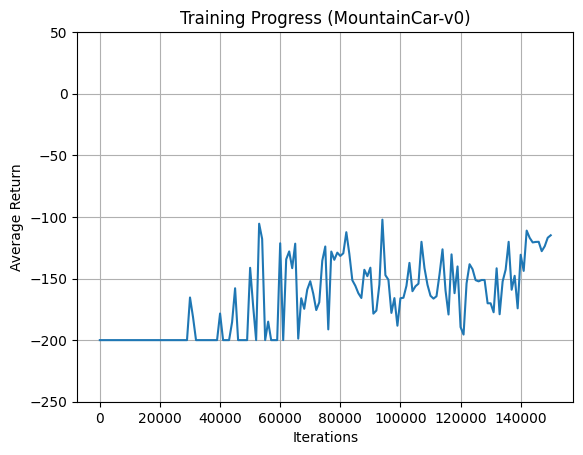

In [ ]:
# In "MountainCar-v0":
# - Each episode lasts up to 200 steps.
# - The agent receives "-1" reward at each time step until it reaches the goal.
# - So, the return is between "-200" (worst) and ~"0" (best).
# Plot how the agent improves over time.

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel("Average Return")
plt.xlabel("Iterations")
plt.title("Training Progress (MountainCar-v0)")
plt.ylim(bottom=-250, top=50)
plt.grid(True)
plt.show()

### Watch the agent learn

Charts are insightful, but watching an agent in action is far more exciting. Therefore, the next step is to visualize how the DQN agent performs in the `MountainCar-v0` environment after training.

The car starts in a valley and must build up enough momentum to climb the opposite hill and reach the flag. Initially, it has no idea how to do that. But after training, it learns to swing back and forth to gain momentum - and eventually succeeds.

Use the environment’s `render()` function to capture each frame and create a video of the agent interacting with the environment. Below is a helper function to embed the video directly in the Colab notebook.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook for playback."""
  # Read the video file in binary mode.
  video = open(filename, "rb").read()

  # Encode the binary data to "base64" for embedding.
  b64 = base64.b64encode(video)

  # Create an HTML5 video tag with the base64-encoded video.
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  # Return the HTML to render in the notebook.
  return IPython.display.HTML(tag)

The following function evaluates the trained agent for a few episodes, recording and saving its performance. Use the function to generate and view the video of the trained agent.

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  # Set the output filename with ".mp4" extension.
  filename = filename + ".mp4"

  # Create a video writer object using "imageio".
  with imageio.get_writer(filename, fps=fps) as video:

    # Run the policy for a specified number of episodes.
    for _ in range(num_episodes):
      # Reset the evaluation environment.
      time_step = eval_env.reset()

      # Append the initial frame to the video.
      video.append_data(eval_py_env.render())

      # Step through the episode until it ends.
      while not time_step.is_last():
        # Get the action from the agent's policy.
        action_step = policy.action(time_step)

        # Apply the action in the environment.
        time_step = eval_env.step(action_step.action)

        # Append the new frame to the video.
        video.append_data(eval_py_env.render())

  # Embed and return the created video in the notebook.
  return embed_mp4(filename)

# Generate and display the video for the trained agent's behavior.
create_policy_eval_video(agent.policy, "trained-agent")

For intuition, go ahead and compare the agent's performance to that of a random agent, which just takes arbitrary actions without learning. The difference is stark - the trained agent learns to reach the goal efficiently, while the random one is unable to make any progress and struggles in the valley.

In [ ]:
# Generate and display the video for a random agent's behavior.
create_policy_eval_video(random_policy, "random-agent")

## Thoughts

The objective of this tutorial was to train a DQN agent to solve `MountainCar-v0`, which is a challenging, sparse-reward environment, where an underpowered car must learn to build momentum to reach a flag. Enhancements used included ε-decay for exploration-exploitation balance, reward shaping to provide learning signals, and hyperparameter tuning. The goal was to have the agent (controlling the mountain car) learn consistent goal-reaching behavior, where it learns to reach the flag efficiently rather than timing out after 200 steps.

The final average return of ~`-114.9` indicates successful learning and near-optimal performance. The agent consistently reaches the goal in approximately 115 steps, well below the 200-step episode limit. The video evidence confirms that the agent learned the correct policy: building momentum through strategic oscillation to climb up the hill.

The learning curve reveals an interesting progression. For the first 29,000 steps, the average returns remained at `-200` as the agent explored randomly with high epsilon values while accumulating experience. The breakthrough around step 30,000 occurred when epsilon had decayed sufficiently to exploit learned patterns, and the replay buffer contained enough successful trajectories. From steps 50,000-100,000, there was notable improvement in observed rewards and learning as the agent learned to refine its policy, with some fluctuations due to ongoing exploration. Finally, convergence around return values of `-115` to `-125` indicates that the agent successfully learned the optimal oscillation strategy. This progression is clearly visible in the training plot, which shows the characteristic plateau followed by breakthrough and gradual convergence.

The enhancements used have significantly aided this work: ε-decay provided proper exploration-exploitation balance, reward shaping (position + velocity bonuses) gave essential learning signals that sparse rewards alone could not provide, and the hyperparameter choices ensured stable learning dynamics. The result is an agent that not only reaches the goal consistently but does so efficiently - exactly what we set out to achieve with this challenging RL problem.

## Next steps

Building on this DQN tutorial, here are worthy improvements and extensions one may explore.

1.   **Double DQN (DDQN)**: Implement [DDQN](https://arxiv.org/abs/1509.06461) to reduce overestimation bias (when the agent / Q-network predicts higher rewards for actions than they actually yield) in Q-value learning. This uses separate Q-networks for action selection and action evaluation (target Q-value computation in our case), often leading to more stable training.

2.   **Dueling DQN**: Try [Dueling Network Architecture](https://arxiv.org/abs/1511.06581) that modifies the Q-network structure to separately estimate "how good it is to be in this state" and "how much better each action is compared to others." This can improve learning efficiency compared to the single-stream `Dense` layer approach, especially when not all actions significantly affect the outcome.

3.   **Prioritized Experience Replay**: Replace uniform sampling with [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952), which samples more important transitions (higher TD error) more frequently, accelerating learning.

4.   **Rainbow DQN**: Combine multiple DQN improvements in the [Rainbow](https://arxiv.org/abs/1710.02298) implementation, which integrates DDQN, Dueling Network Architecture, Prioritized Experience Replay, and other enhancements.

5.   **Different Environments**: Apply the same techniques to other classic control problems like `CartPole-v1`, `Acrobot-v1`, or `LunarLander-v3` to understand how reward shaping and hyperparameters transfer across tasks.

6.   **Continuous Control**: Explore policy gradient methods like [PPO](https://arxiv.org/abs/1707.06347) or [SAC](https://arxiv.org/abs/1801.01290) on continuous action spaces such as `MountainCarContinuous-v0` or `Pendulum-v1`.

7.   **Hyperparameter Optimization**: Use approaches like [Optuna](https://optuna.org/) or [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) to automatically find optimal learning rates, network architectures, and epsilon decay schedules.

8.   **Multi-Agent Learning**: Extend to multi-agent scenarios using frameworks like [PettingZoo](https://pettingzoo.farama.org/) to study cooperation and competition between multiple learning agents.

9.   **Custom Reward Shaping**: Experiment with different reward shaping functions or learn to automatically shape rewards using techniques like [potential-based reward shaping](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/NgHaradaRussell-shaping-ICML1999.pdf).

10.   **Transfer Learning**: Pre-train on one environment variant and fine-tune on another one (e.g., different mountain slopes) to study how learned policies transfer across similar tasks.